Mass Changes- (Preprocessing.DataAugementation and Labeling), Loss Function, Dataset Structure, Prediction Results

In [1]:
(1)
# Data Processing and Visualization
import os
import random
import glob
import re

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math
import imgaug.augmenters as iaa  # For mild data augmentation

# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image
# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf

# Specific TensorFlow/Keras Components
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from IPython.display import display
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy


Datamap imports the path of images and store them to a variable

In [2]:
(2)
datamap = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Dataset_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Load the image as an array
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            # Check if the image is successfully loaded
            if image is not None:
                # Append a dictionary to the datamap
                datamap.append({
                    'tumor_type': dir_name,
                    'file_name': filename,
                    'file_path': image_path,  # Include the full file path
                    'image': image
                })

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")


Tumor Type: Astrocytoma, File Name: 0.png, File Path: Dataset_MRI\Astrocytoma\0.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 1.png, File Path: Dataset_MRI\Astrocytoma\1.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 10.png, File Path: Dataset_MRI\Astrocytoma\10.png, Image Shape: (630, 536, 3)
Tumor Type: Astrocytoma, File Name: 2.png, File Path: Dataset_MRI\Astrocytoma\2.png, Image Shape: (630, 512, 3)
Tumor Type: Astrocytoma, File Name: 3.png, File Path: Dataset_MRI\Astrocytoma\3.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 4.png, File Path: Dataset_MRI\Astrocytoma\4.png, Image Shape: (630, 586, 3)
Tumor Type: Astrocytoma, File Name: 5.png, File Path: Dataset_MRI\Astrocytoma\5.png, Image Shape: (630, 630, 3)
Tumor Type: Astrocytoma, File Name: 6.png, File Path: Dataset_MRI\Astrocytoma\6.png, Image Shape: (630, 536, 3)
Tumor Type: Astrocytoma, File Name: 7.png, File Path: Dataset_MRI\Astrocytoma\7.png, Image Shape: (630

Coverting the datamap to dataframe

In [3]:
(3)
# Convert the data_map to a pandas DataFrame Display the first few rows
datamap_df = pd.DataFrame(datamap)
print(datamap_df.head())
# print(df)

    tumor_type file_name                       file_path  \
0  Astrocytoma     0.png   Dataset_MRI\Astrocytoma\0.png   
1  Astrocytoma     1.png   Dataset_MRI\Astrocytoma\1.png   
2  Astrocytoma    10.png  Dataset_MRI\Astrocytoma\10.png   
3  Astrocytoma     2.png   Dataset_MRI\Astrocytoma\2.png   
4  Astrocytoma     3.png   Dataset_MRI\Astrocytoma\3.png   

                                               image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[10, 10, 10], [10, 10, 10], [11, 11, 11], [1...  
3  [[[5, 5, 5], [5, 5, 5], [5, 5, 5], [6, 6, 6], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  


Displaying the images before pre-processing

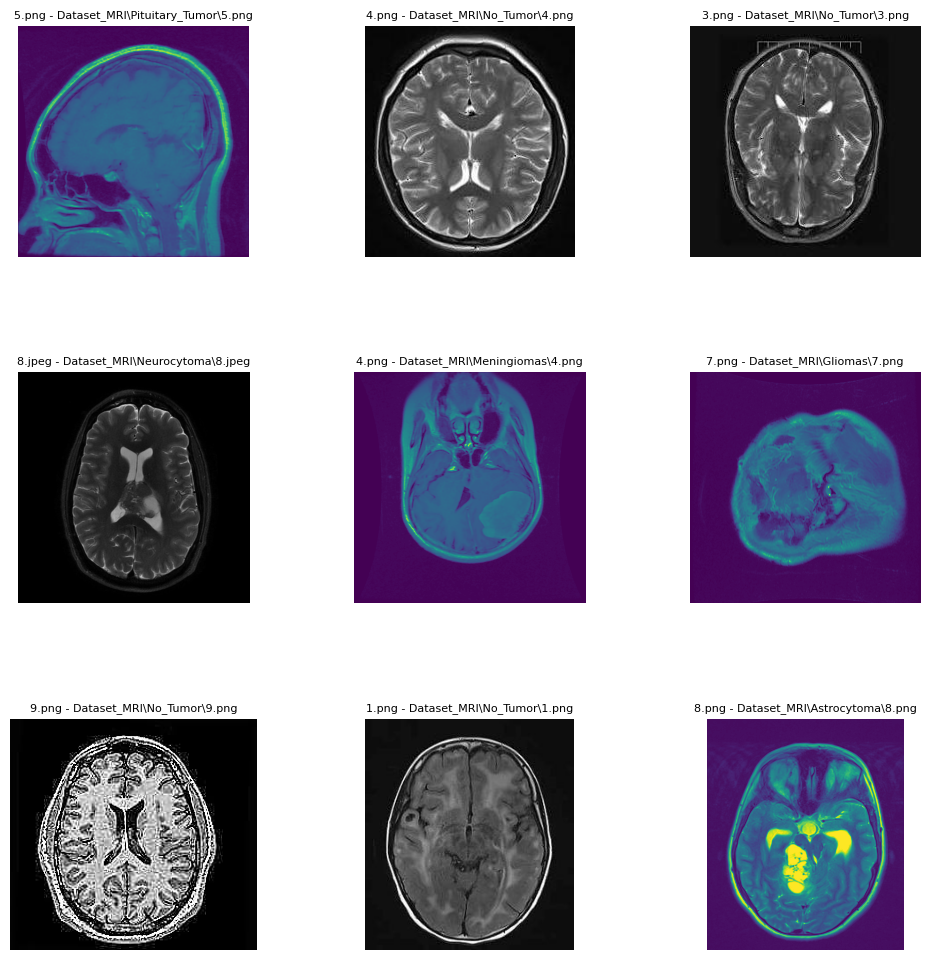

In [4]:
(4)

num_images_to_display = 9
num_cols = 3
num_rows = 3  # Since num_images_to_display is 9 and num_cols is 3

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Select random rows from the DataFrame
random_rows = datamap_df.sample(n=num_images_to_display)

# Iterate through the randomly selected rows to display images
for idx, (index, row) in enumerate(random_rows.iterrows()):
    # Determine the current row and column for the subplot
    current_row, current_col = divmod(idx, num_cols)

    # Load the image
    img = Image.open(row['file_path'])

    # Display the image
    axes[current_row, current_col].imshow(img)

    # Set title as 'file_name - file_path'
    title_text = f"{row['file_name']} - {row['file_path']}"
    axes[current_row, current_col].set_title(title_text, fontsize=8)  # Adjust fontsize as needed

    axes[current_row, current_col].axis('off')

# Hide any empty subplots if necessary
for i in range(idx + 1, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

# Adjust subplot spacing and display the figure
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


Split data into training, testing, validation

In [5]:
(5)
# Import necessary libraries for splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Split your data into training and validation sets
train_df, val_df = train_test_split(datamap_df, test_size=0.2, random_state=42)

# Ensure file paths are strings
train_df['file_path'] = train_df['file_path'].astype(str)
val_df['file_path'] = val_df['file_path'].astype(str)

# train_df and val_df are now ready for use
print("Size of train_df:", len(train_df))
print("Size of val_df:", len(val_df))


Size of train_df: 60
Size of val_df: 16


In [80]:
(6)

# Tumor type labels mapping
tumor_labels = {
    'Astrocytoma': 0,
    'Glioblastoma': 1,
    'Gliomas': 2,
    'Meningiomas': 3,
    'Neurocytoma': 4,
    'No_Tumor': 5,
    'Pituitary_Tumor': 6
}

# Instantiate a LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder with all the possible class names (ensure they are in the correct order)
all_classes = ['Astrocytoma', 'Glioblastoma', 'Gliomas', 'Meningiomas', 'Neurocytoma', 'No_Tumor', 'Pituitary_Tumor']
label_encoder.fit(all_classes)

# Apply tumor type labels to the DataFrame using the label encoder
train_df['encoded_labels'] = label_encoder.transform(train_df['tumor_type'])
val_df['encoded_labels'] = label_encoder.transform(val_df['tumor_type'])

# Print out the encoded label for each class name to verify
for class_name in all_classes:
    encoded_label = label_encoder.transform([class_name])[0]
    print(f"Class Name: {class_name}, Encoded Label: {encoded_label}")

# Prepare image paths and labels for the generators
train_image_paths = train_df['file_path'].tolist()
train_labels = train_df['encoded_labels'].tolist()

val_image_paths = val_df['file_path'].tolist()
val_labels = val_df['encoded_labels'].tolist()


Class Name: Astrocytoma, Encoded Label: 0
Class Name: Glioblastoma, Encoded Label: 1
Class Name: Gliomas, Encoded Label: 2
Class Name: Meningiomas, Encoded Label: 3
Class Name: Neurocytoma, Encoded Label: 4
Class Name: No_Tumor, Encoded Label: 5
Class Name: Pituitary_Tumor, Encoded Label: 6


Data Generator

In [106]:
(7)

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels  # Assuming labels are already one-hot encoded
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Adjusted data augmentation to be milder
        self.augmenter = iaa.Sequential([
            iaa.Fliplr(0.5),  # Horizontal flips
            iaa.Affine(rotate=(-5, 5)),  # Mild rotation
            iaa.Multiply((0.95, 1.05)),  # Mild brightness adjustment
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        # Generates a batch of data
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]

        # Diagnostic print
        print(f'__getitem__ index: {index}')
        for i, path in enumerate(batch_image_paths):
            print(f'Batch {index} - image path {i}: {path}')

        X, y = self.__generate_Xy(batch_image_paths, batch_labels)
        return X, y
    
    # New method for debugging
    def get_image_path_and_label(self, global_index):
        # Access the image path and label using the global index
        image_path = self.image_paths[global_index]
        label = self.labels[global_index]  # Make sure labels are not one-hot encoded here
        return image_path, label
    def direct_fetch_test(self, global_index):
        image_path = self.image_paths[global_index]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.image_size)
        image = np.expand_dims(image, axis=-1)
        image = image.astype(np.float32) / 255.0

        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Direct Fetch Test: {image_path}")
        plt.axis('off')
        plt.show()


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_Xy(self, batch_image_paths, batch_labels):
        X = np.empty((len(batch_image_paths), *self.image_size, 1))  # Change the channel size to 1 for grayscale
        y = np.empty((len(batch_image_paths), self.num_classes))
        
        # Diagnostic print
        for i, path in enumerate(batch_image_paths):
            print(f'__generate_Xy - image path {i}: {path}')

        for i, (path, label) in enumerate(zip(batch_image_paths, batch_labels)):
            # image = cv2.imread(path) # This is Temp Remove this after testing
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
            image = cv2.resize(image, self.image_size)  # Resize images
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            image = image.astype(np.float32) / 255.0  # Normalize to [0, 1] range

            # Apply mild data augmentation
            image = self.augmenter.augment_image(image)

            X[i,] = image
            y[i,] = label  # Assuming labels are already one-hot encoded

        return X, y


# Parameters for the data generator
batch_size = 32  # Example batch size, adjust as needed
image_size = (256, 256)  # Target image size as per the model input
num_classes = 7  # Adjust based on the number of tumor types or categories

# Instantiate the custom data generators with encoded labels
train_generator = CustomDataGenerator(
    image_paths=train_df['file_path'].tolist(),
    labels=train_df['encoded_labels'].tolist(),  # Use encoded labels
    batch_size=batch_size,
    image_size=image_size,
    num_classes=num_classes,
    shuffle=True
)

val_generator = CustomDataGenerator(
    image_paths=val_df['file_path'].tolist(),
    labels=val_df['encoded_labels'].tolist(),  # Use encoded labels
    batch_size=batch_size,
    image_size=image_size,
    num_classes=num_classes,
    shuffle=False
)

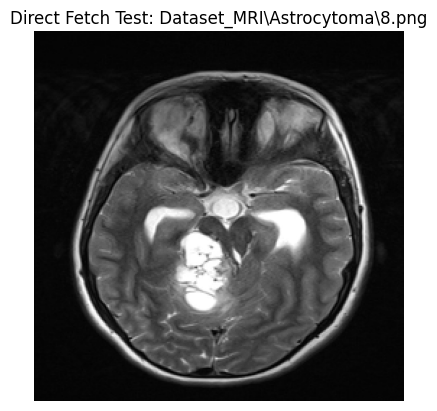

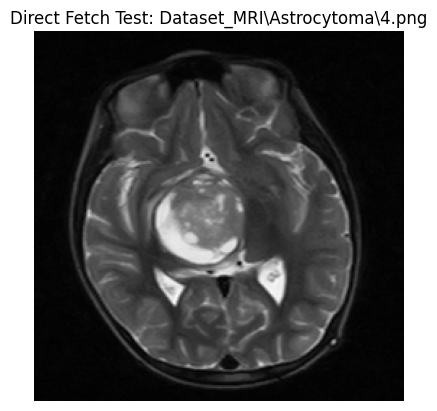

In [107]:
# Example usage
train_generator.direct_fetch_test(0)
train_generator.direct_fetch_test(1)


Visuals of Preprocessing

__getitem__ index: 0
Batch 0 - image path 0: Dataset_MRI\No_Tumor\4.png
Batch 0 - image path 1: Dataset_MRI\Neurocytoma\0.jpeg
Batch 0 - image path 2: Dataset_MRI\Neurocytoma\2.jpg
Batch 0 - image path 3: Dataset_MRI\No_Tumor\8.png
Batch 0 - image path 4: Dataset_MRI\Astrocytoma\2.png
Batch 0 - image path 5: Dataset_MRI\Gliomas\5.png
Batch 0 - image path 6: Dataset_MRI\Glioblastoma\6.png
Batch 0 - image path 7: Dataset_MRI\Pituitary_Tumor\3.png
Batch 0 - image path 8: Dataset_MRI\Neurocytoma\8.jpeg
Batch 0 - image path 9: Dataset_MRI\Gliomas\3.png
Batch 0 - image path 10: Dataset_MRI\No_Tumor\0.png
Batch 0 - image path 11: Dataset_MRI\Gliomas\2.png
Batch 0 - image path 12: Dataset_MRI\Astrocytoma\7.png
Batch 0 - image path 13: Dataset_MRI\Pituitary_Tumor\1.png
Batch 0 - image path 14: Dataset_MRI\Glioblastoma\8.png
Batch 0 - image path 15: Dataset_MRI\Gliomas\0.png
Batch 0 - image path 16: Dataset_MRI\Pituitary_Tumor\6.png
Batch 0 - image path 17: Dataset_MRI\No_Tumor\5.png
Batch 0 - i

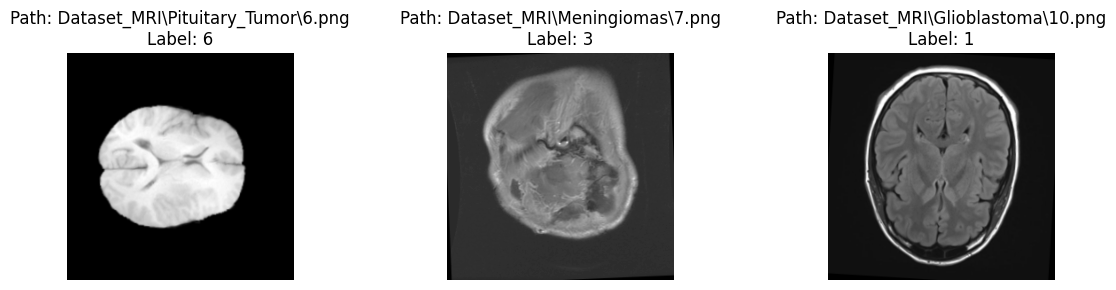

In [99]:
(8)
# Number of images to display
num_images_to_display = 3

# Randomly select a batch
batch_index = np.random.randint(0, len(train_generator))
X_batch, y_batch = train_generator.__getitem__(batch_index)

# Randomly select images from the batch
selected_indices = np.random.choice(X_batch.shape[0], num_images_to_display, replace=False)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(selected_indices):
    # Calculate the global index in the dataset, considering the batch offset
    global_idx = batch_index * train_generator.batch_size + idx

    # Use the generator method to fetch the correct path and label
    image_path, label = train_generator.get_image_path_and_label(global_idx)
    
    # Fetch the corresponding image from the batch using idx
    image = X_batch[idx].squeeze()  # Squeeze in case the image has an extra singleton dimension
    
    # Debugging print to check if the fetched image matches the path
    print(f"Displaying image at: {image_path}")
    print(f"Label: {label}")
    
    # Check the shape of the fetched image
    print(f"Shape of the fetched image: {image.shape}")
    
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(image, cmap='gray')  # Assuming grayscale images
    plt.title(f"Path: {image_path}\nLabel: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()



Model

In [17]:
(9)
#custom UNET & VGG16 model
def vgg16_unet_model(input_shape=(256, 256, 3), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder - Inspired by VGG16
    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Global Average Pooling to aggregate spatial information
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers for classification
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Construct model
    model = models.Model(inputs, outputs, name='Custom-VGG16_UNET-Model')
    return model

# Model parameters
num_classes = 7  # Adjust based on your specific task

# Build and compile the model
model = vgg16_unet_model(num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()




Model: "Custom-VGG16_UNET-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                         

Custom Loss Function

In [30]:
(10)
#Custom Loss function
epsilon = 1e-5
smooth = 1

def categorical_tversky_index(y_true, y_pred, alpha=0.7):
    # Get the dynamic shape
    shape = tf.shape(y_true)
    y_true = K.reshape(y_true, [-1, shape[-3], shape[-2], shape[-1]])
    y_pred = K.reshape(y_pred, [-1, shape[-3], shape[-2], shape[-1]])

    # Calculate Tversky index for each pixel and then average over all pixels
    true_positives = K.sum(y_true * y_pred, axis=[1, 2])
    false_negatives = K.sum(y_true * (1 - y_pred), axis=[1, 2])
    false_positives = K.sum((1 - y_true) * y_pred, axis=[1, 2])

    tversky_index = (true_positives + smooth) / (true_positives + alpha * false_negatives + (1 - alpha) * false_positives + smooth)
    return K.mean(tversky_index)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tversky_index = categorical_tversky_index(y_true, y_pred)
    return K.pow((1 - tversky_index), gamma)

# Custom loss function
def categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Assuming focal_tversky_loss is your chosen custom loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Checkpoints

In [31]:
(11)
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, csv_filename="Model_Weights/training_history.csv"):
        super(SaveHistoryCallback, self).__init__()
        self.csv_filename = csv_filename
        self.epoch_history = []
        # Load existing history if it exists to maintain continuity
        if os.path.exists(self.csv_filename):
            self.epoch_history = pd.read_csv(self.csv_filename).to_dict('records')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Adjust epoch number based on existing records
        current_epoch = epoch + 1 if not self.epoch_history else self.epoch_history[-1].get('epoch', epoch) + 1
        logs['epoch'] = current_epoch
        self.epoch_history.append(logs)
        # Ensure 'epoch' is the first column
        df = pd.DataFrame(self.epoch_history)
        cols = ['epoch'] + [col for col in df.columns if col != 'epoch']
        df = df[cols]
        # Save updated history ensuring 'epoch' is first
        df.to_csv(self.csv_filename, index=False)

# Instantiate callbacks
csv_filename = "Model_Weights/training_history.csv" 
save_history_callback = SaveHistoryCallback(csv_filename)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
checkpointer = ModelCheckpoint(filepath="Model_Weights/brain_tumor_model_weights.hdf5", verbose=1, save_best_only=True, save_weights_only=False, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=0.000001, verbose=1)

# Assuming custom_rgb_model is already defined
adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
# Compiling 
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# Assuming focal_tversky_loss is your chosen custom loss function
model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy'])



setup epoch latest value

In [32]:
(12)
# Check and read the existing CSV, if available
if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    # Ensure 'epoch' is the first column by reordering if it's not
    if 'epoch' in existing_df.columns:
        cols = ['epoch'] + [col for col in existing_df.columns if col != 'epoch']
        existing_df = existing_df[cols]
    existing_df.to_csv(csv_filename, index=False)
else:
    # If the CSV doesn't exist, no action is needed here
    pass

Loading the model checkpoint

In [33]:
(13)
model_path = "Model_Weights/brain_tumor_model_weights.hdf5"
if os.path.exists(model_path):
    custom_model = load_model(model_path, custom_objects={'categorical_crossentropy': categorical_crossentropy})
    print("Model loaded successfully.")
else:
    print("Starting training from scratch.")

Starting training from scratch.


In [34]:
# Access the first batch directly
X_batch, y_batch = train_generator[0]
print(y_batch.shape)  # This should work if your generator is correctly implemented


(32, 7)


Epochs

In [35]:
(14)
# Total number of epochs to train
total_epochs = 200
# Train the model with the callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    callbacks=[early_stopping, reduce_lr, checkpointer, save_history_callback],
    verbose=1
)

# Access the entire training history
entire_training_history = save_history_callback.epoch_history


Epoch 1/200


ValueError: in user code:

    File "C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Implici7\AppData\Local\Temp\ipykernel_10984\3096242312.py", line 27, in categorical_crossentropy  *
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))
    File "C:\Users\Implici7\AppData\Local\Temp\ipykernel_10984\898696676.py", line 9, in categorical_tversky_index  *
        y_true = K.reshape(y_true, [-1, shape[-3], shape[-2], shape[-1]])

    ValueError: slice index -1 of dimension 0 out of bounds. for '{{node categorical_crossentropy/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](categorical_crossentropy/Shape, categorical_crossentropy/strided_slice/stack, categorical_crossentropy/strided_slice/stack_1, categorical_crossentropy/strided_slice/stack_2)' with input shapes: [2], [1], [1], [1] and with computed input tensors: input[1] = <-3>, input[2] = <-2>, input[3] = <1>.


Predictions

In [ ]:
import os

image_path = 'Dataset_MRI/Astrocytoma/0.png'
if os.path.exists(image_path):
    img = preprocess_image(image_path)
else:
    print(f"Image file does not exist at path: {image_path}")


In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image at path: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img


In [ ]:

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess the image for model prediction."""
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img = img_to_array(img)  # Convert the image to a numpy array
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img /= 255.0  # Normalize the image to [0, 1]
    return img

# Path to your test image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this path to your specific image

# Preprocess the image
img = preprocess_image(image_path)

# Ensure 'class_names' is correctly defined. This dictionary should match the structure you expect from your model's output.
class_names = {0: 'No Tumor', 1: 'Gliomas', 2: 'Meningiomas', 3: 'Pituitary_Tumor', 4: 'Astrocytoma', 5: 'Glioblastoma', 6: 'Neurocytoma'}


In [ ]:
# Load and preprocess an input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img /= 255.0  # Normalize pixel values
    return img

# Specify the path to your image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this to the correct path for your image
img = preprocess_image(image_path)

# Use the model to make a prediction on the preprocessed image
predictions = custom_rgb_model.predict(img)

# Now, you can print the shape of the predictions array
print(predictions.shape)



1/1 [==============================] - 0s 278ms/step
(1, 256, 256, 7)


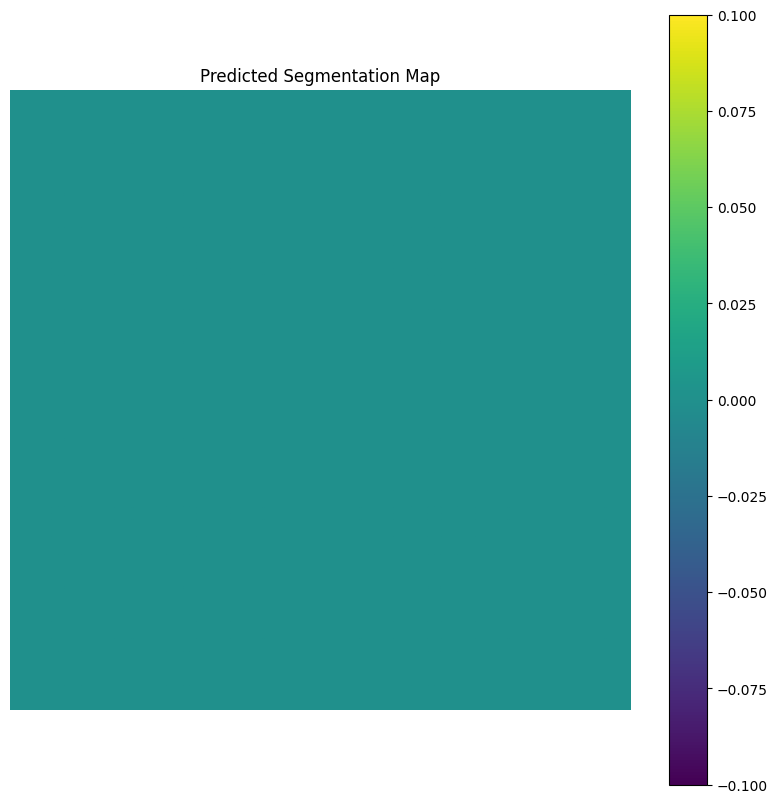

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions shape is (1, 256, 256, 7)
segmentation_map = np.argmax(predictions[0], axis=-1)  # This will have the shape (256, 256)

# Now, segmentation_map contains the predicted class for each pixel

plt.figure(figsize=(10, 10))
plt.imshow(segmentation_map, cmap='viridis')  # You can choose a colormap that fits your needs
plt.colorbar()  # Optionally add a colorbar to understand which values correspond to which classes
plt.title("Predicted Segmentation Map")
plt.axis('off')
plt.show()


Graphs

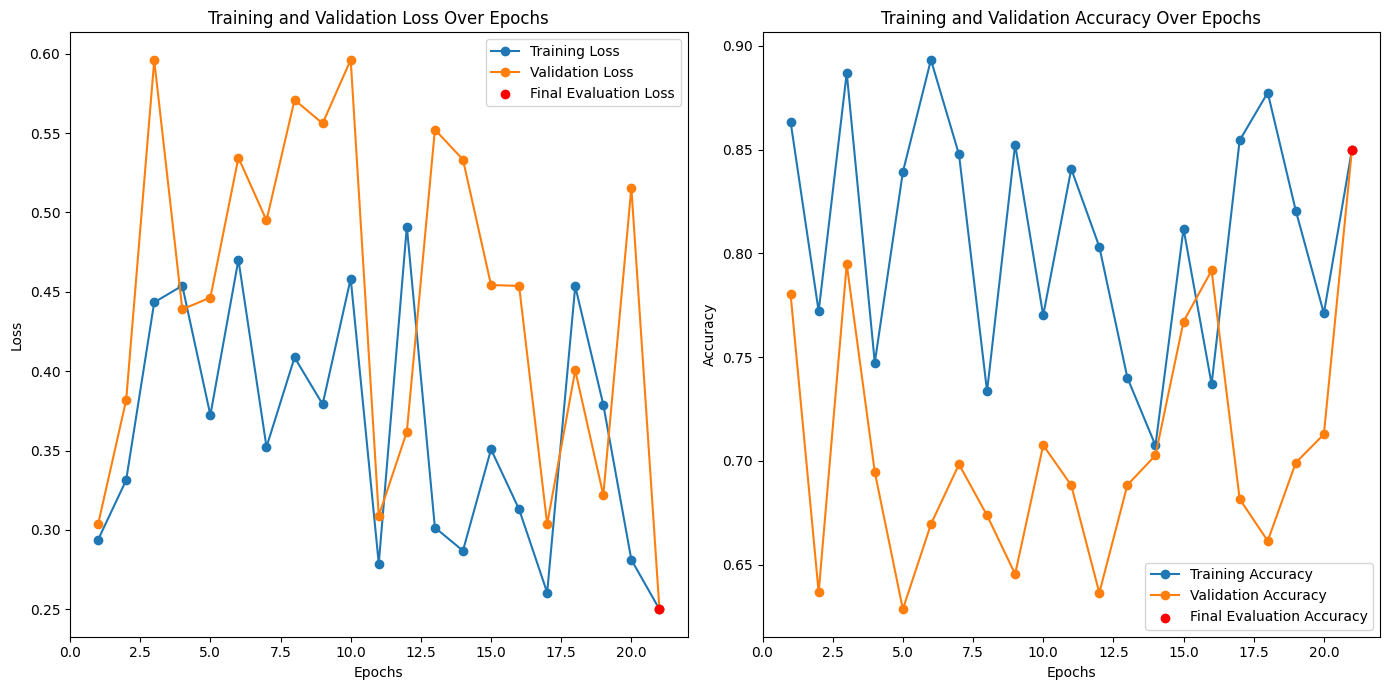

In [43]:
# Placeholder historical data (replace these with your actual training history)
epochs = np.arange(1, 21)  # Example: 20 epochs
historical_train_losses = np.random.uniform(0.2, 0.5, size=20)  # Simulated data
historical_val_losses = np.random.uniform(0.3, 0.6, size=20)  # Simulated data
historical_train_accuracies = np.random.uniform(0.7, 0.9, size=20)  # Simulated data
historical_val_accuracies = np.random.uniform(0.6, 0.8, size=20)  # Simulated data

# Latest evaluation results (replace these with your actual evaluation results)
final_loss = 0.25  # Example loss
final_accuracy = 0.85  # Example accuracy

# Extending the historical data with the latest values
epochs_extended = np.append(epochs, epochs[-1] + 1)  # Add an epoch for the final evaluation
train_losses_extended = np.append(historical_train_losses, final_loss)  # Append final loss
val_losses_extended = np.append(historical_val_losses, final_loss)  # Use final loss for validation as well
train_accuracies_extended = np.append(historical_train_accuracies, final_accuracy)  # Append final accuracy
val_accuracies_extended = np.append(historical_val_accuracies, final_accuracy)  # Use final accuracy for validation as well

# Plotting
plt.figure(figsize=(14, 7))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_extended, train_losses_extended, label='Training Loss', marker='o')
plt.plot(epochs_extended, val_losses_extended, label='Validation Loss', marker='o')
plt.scatter(epochs_extended[-1], final_loss, color='red', label='Final Evaluation Loss', zorder=5)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_extended, train_accuracies_extended, label='Training Accuracy', marker='o')
plt.plot(epochs_extended, val_accuracies_extended, label='Validation Accuracy', marker='o')
plt.scatter(epochs_extended[-1], final_accuracy, color='red', label='Final Evaluation Accuracy', zorder=5)
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
